<a href="https://colab.research.google.com/github/remytr/Black-Scholes-Model/blob/main/Crank_Nicholson_with_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implicit Crank-Nicholson Finite Difference Method

Black-Scholes formula using Crank-Nicholson Finite Difference Method. More robust, stable, and accurate compared to explicit finite difference method.

Crank-Nicholson is a mix between explicit and implicit methods. It uses the current time step values from the Explicit method to estimate future values. It takes the stability and accuracy from the implicit method.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
plt.style.use('ggplot')

In [1]:
def crank_nicholson(type, expiration, sigma, r, strike, NAS, NTS):

    # Initialise parameteres.
    S_min = strike/3
    S_max = strike*2

    dS = (S_max-S_min)/NAS
    dt = expiration/NTS

    S = np.arange(0, NAS+1)* dS +S_min

    V = np.zeros((NAS + 1, NTS + 1))

    # Set up grid with boundary conditions.
    # Coefficients alpha, beta, gamma are part of the matrix of linear equations from the discretization of the Black-Scholes PDE.

    payoff = np.maximum((strike-S), 0)
    V[:, -1] = payoff
    V[-1, :] = 0
    V[0, :] = np.maximum(strike - S_min, 0) * np.exp(-r * np.linspace(0, expiration, NTS + 1)[::-1])

    I = np.arange(0,NAS+1)

    alpha = 0.25 * dt * ((sigma**2) * (I**2) - r*I)
    beta = -dt * 0.5 * (sigma**2 * (I**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (I**2) + r * I)

    # ML matrix is used to represent the current time step.
    # MR matrix is used for the next time step.
    # Uses sparse matrices. They store only non-zero elements.
    ML = sparse.diags([-alpha[2:], 1-beta[1:], -gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()
    MR = sparse.diags([alpha[2:], 1+beta[1:], gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()

    for t in range(NTS - 1, -1, -1):
        boundary_t = np.zeros(NAS - 1)
        boundary_t[0] = alpha[1] * (V[0, t] + V[0, t + 1]) -alpha[0] * V[0, t + 1]
        boundary_t[-1] = gamma[NAS - 1] * (V[NAS, t] + V[NAS, t + 1])
        b = MR.dot(V[1:NAS, t + 1]) + boundary_t
        V[1:NAS, t] = spsolve(ML, b)
        #V[0, t] = 2 * V[1, t] - V[2, t]


    asset_range = np.arange(0, NAS + 1) * dS  + S_min  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)

    return df

In [3]:
K =100
sigma = 0.2
r = 0.1
q = 0
expiration = 1
NAS = 200
NTS = 300
type = "call"

option_df = crank_nicholson(type = type, strike = K, sigma = sigma, r = r,
                             expiration = expiration,
                             NAS = NAS, NTS = NTS)

In [4]:
option_df

,0.000,0.003,0.007,0.010,0.013,0.017,0.020,0.023,0.027,0.030,...,0.970,0.973,0.977,0.980,0.983,0.987,0.990,0.993,0.997,1.000
33.333333,60.322,60.343,60.363,60.383,60.403,60.423,60.443,60.463,60.484,60.504,...,66.467,66.489,66.511,66.533,66.556,66.578,66.600,66.622,66.644,66.667
34.166667,59.489,59.509,59.529,59.550,59.570,59.590,59.610,59.630,59.650,59.670,...,65.634,65.656,65.678,65.700,65.722,65.745,65.767,65.789,65.811,65.833
35.000000,58.656,58.676,58.696,58.716,58.736,58.756,58.777,58.797,58.817,58.837,...,64.800,64.822,64.845,64.867,64.889,64.911,64.933,64.956,64.978,65.000
35.833333,57.822,57.843,57.863,57.883,57.903,57.923,57.943,57.963,57.984,58.004,...,63.967,63.989,64.011,64.033,64.056,64.078,64.100,64.122,64.144,64.167
36.666667,56.989,57.009,57.029,57.050,57.070,57.090,57.110,57.130,57.150,57.170,...,63.134,63.156,63.178,63.200,63.222,63.245,63.267,63.289,63.311,63.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196.666667,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
197.500000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
198.333333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
199.166667,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


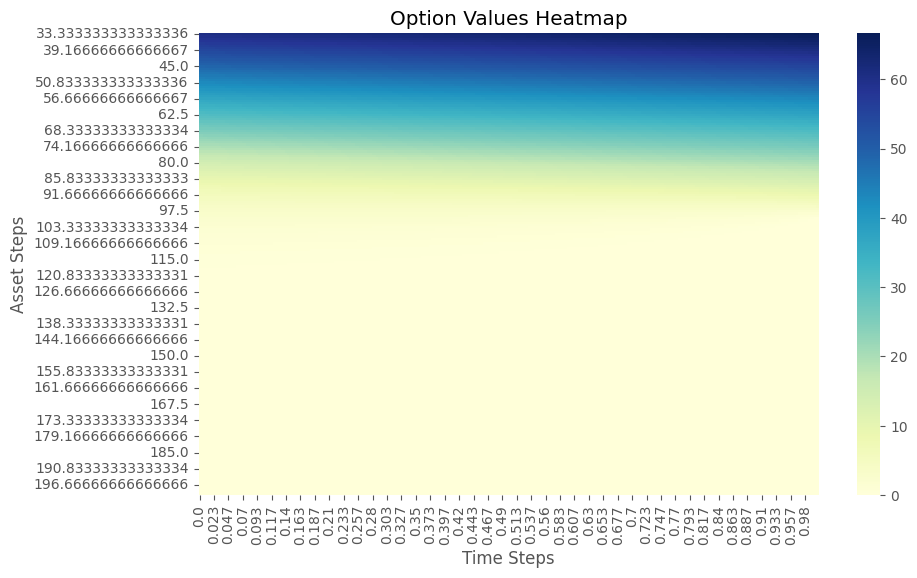

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(option_df, cmap='YlGnBu', fmt=".3f")
plt.title('Option Values Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Asset Steps')
plt.show()

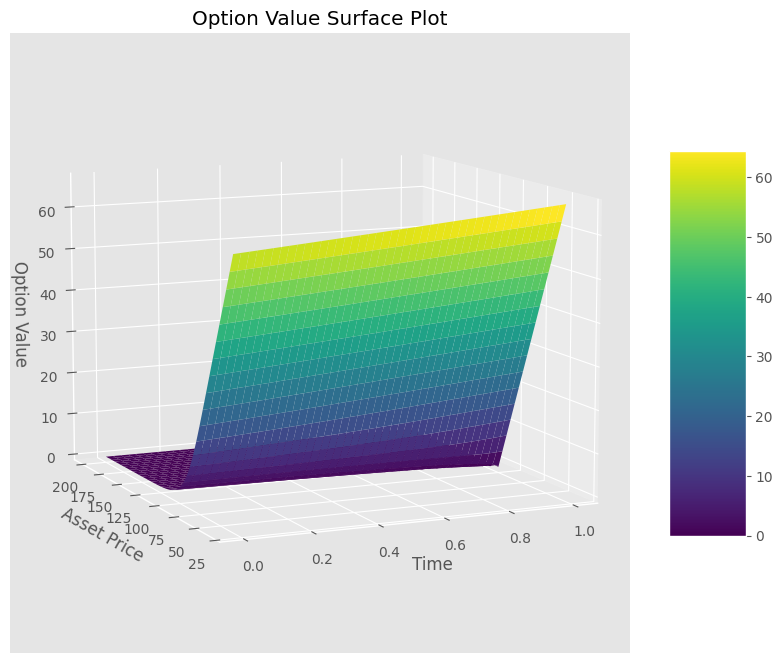

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

plot_df = option_df
X, Y = np.meshgrid(plot_df.columns, plot_df.index)
Z = plot_df.values

surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(10, 196+50)

plt.show()